### [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=3356s)

### [chatGPT-4, released on 2023-03-14, has 1 trillion paramaters and cost $100 million to train](https://en.wikipedia.org/wiki/GPT-4)

In [69]:
import math, random, torch
import numpy as np
# import random
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
# verbose = True   # print calculation output and weights and bias matrices 
verbose = False  # print calculation output only

In [71]:
def plot_losses(losses):
  # import matplotlib.pyplot as plt
  
  # Create a list of iterations
  iterations = range(len(losses))

  # Plot the loss as a function of iteration
  plt.plot(iterations, losses)

  # Add a title to the plot
  plt.title('Loss vs. Iteration')

  # Add labels to the x-axis and y-axis
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

In [72]:
def print_parameters(parameters):
  # number of parameters (e.g sum (weights + bias to each neuron and output))
  # MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
  # print(f'Number of parameters in MLP(2, [3, 3, 1]): {len(parameters())}\n')
  print(f'Total parameters: {len(parameters())}\n')  

  # print first 5 parameters
  for i, v in enumerate(parameters()):
    if i < 5:
      print(f'i: {i:>2}, {v.data:>14.10f}')
  
  print('---')

  # print last 5 parameters   
  for i, v in enumerate(parameters()):
    if i >= len(parameters()) - 5:
      print(f'i: {i:>2}, {v.data:>14.10f}')

In [73]:
def get_wt_n_b_mats(layers, verbose=False):
  ''' Get neuron's weights and bias for each layer.
  Inputs: If n = MLP(2, [3, 3, 1]), input is n.layers.

  return: two lists of np.arrays. The first list is weight matrix for each layer
          The second list is the bias matrix for each layer 
  '''
  layer_cnt = len(layers)  # number of layers
  w_mats = []  # list of weights matrix for each layer 
  b_mats = []  # list of bias matrix for each layer
  if verbose:
    print(f'layer_cnt: {layer_cnt}\n')
  for i, layer in enumerate(layers):
      neuron_cnt = len(layer.neurons)  # numbers of neurons in the layer
      if verbose: 
        print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

        print('----')
      b_mat = []  # accumulate neuon's bias for each row     
      for j, neuron in enumerate(layer.neurons):
          if verbose:
            print(f'layer: {i}, neuron {j}')
          b = neuron.b.data  # bias of neuron 
          w_row = []  # accumulate neuon's weights for each row
          b_row = []  # accumulate neuon's bias for each row
          for k, w in enumerate(neuron.w):
              w_row.append(w.data)
              if verbose:
                print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
          if j == 0:            
              w_mat = np.array([w_row])
          else:
              w_mat = np.vstack((w_mat, w_row))
          
          b_mat.append(b)
          if verbose:
            print(f'b:  {b:10.7f}\n')
            print(f'b:  {b:10.7f}')        
            print(f'b_mat:  {b_mat}\n')
      w_mats.append(w_mat)  
      b_mats.append(np.array([b_mat]))        
      if verbose:
          print('------')

  zipped_w_n_b = zip(w_mats, b_mats)
  if verbose:
    for i, w_n_b in enumerate(zipped_w_n_b):
      print(f'layer: {i}')  # 1st layer is 0    
      print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
      print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  

  return w_mats, b_mats

In [74]:
def forward_pass(layers, verbose=verbose):
  # Get Neural Network's Weights and Biases Matrices
  # w_mats, b_mats = get_wt_n_b_mats(n.layers, verbose=verbose)
  w_mats, b_mats = get_wt_n_b_mats(layers, verbose=verbose)

  # Calculate Neural Network Output and Loss with Matrix Multiplication
  for layer in range(len(layers)):
    if layer == 0:  # first layer, use given inputs xs as inputs
      input = xs_mats_T[layer]
    else:  # after first layer, use outputs from preceding layers as inputs
      input = output

    weights = w_mats[layer]
    bias = np.transpose(b_mats[layer])

    weights_x_input = np.matmul(weights, input)
    weights_x_input_plus_bias = weights_x_input + bias

    # output = np.tanh(np.matmul(weights, input) + bias)
    output = np.tanh(weights_x_input_plus_bias)

    print(f'{"-"*50}')
    print(f'Calculate Output of Layer: {layer}')    
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_+_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')    

    # print(f'output = tanh(weights_x_inputs_+_bias) {output.shape}:\n{output}\n')    
    print(f'Layer {layer} Output = tanh(weights_x_inputs_+_bias) {output.shape}:\n{output}\n')    

  yout = output[0]
  err = (yout - ys)
  err_sq = (err**2)
  loss_sum = err_sq.sum()
  loss_mean = err_sq.mean()

  # print(f'-- Manual calculation results of neural network output and prediction error --')
  print(f'-- Results of neural network outputs and Loss --')  
  print(f'yout:           {yout}')   
  print(f'desired output: {ys}')   
  print(f'err:            {err}')
  print(f'err_sq:         {err_sq}')
  print(f'loss_sum:       {loss_sum}')
  print(f'loss_mean:      {loss_mean}')

  return yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats


### Micrograd Classes and Functions<br>* limited to neural network with one output, e.g. MLP(2, [3, 1])<br>* neural network with multiple outputs, e.g.  MLP(2, [3, 3]), will produce errors in backward pass 

In [75]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [76]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [77]:
class Neuron:
    
    def __init__(self, nin):
        # random numbers evenly distributed between -1 and 1    
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

#   &nbsp;
# - Human Brain and Artificial Neural Network - 

### Neurons in Human Brain
![](..\karpathy\img\neuron_of_human_brain.png)

### Artificial Neuron Function

<img src="..\karpathy\img\Artificial Neuron Function.png">

### Simple Artificial Neural Network<br>* input layer: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2 nodes<br>* hidden layer 1: &nbsp;3 nodes<br>* hidden layer 2:&nbsp;&nbsp;3 nodes<br>*  output layer: &nbsp;&nbsp;&nbsp; 1 node<br>* node's bias and activation function are not shown

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\MLP (2, [3, 3, 1]).png">

# &nbsp;
# - Visualize Math Operations in a Hidden Layer -

### * Assume hidden layer with two inputs (X0, X1), and three neurons (b0, b1, b2)<br>* Two sets of inputs (X0, X1) are shown in different shades of gray<br>* Two sets of outputs (Y0, Y1, Y2) are shown in corresponding shades of gray<br>* Both sets of inputs are processed in one matrix operation 

<img src="..\karpathy\img\Hidden Layer Matrix Operations.png">

# &nbsp;
# - Create Simple Neural Network with Micrograd -
##### MLP(2, [3, 3, 1])<br>* 2 input nodes<br>* 3 neurons in hidden layer 1<br>* 3 neurons in hidden layer 2<br>* 1 output node
##### Initialize Neurons Parameters <br>* parameters in layer 1: 3 neurons * (2 inputs + 1 bias) = &nbsp;&nbsp;&nbsp;&nbsp;  9<br>* parameters in layer 2: 3 neurons * (3 neurons + 1 bias) = 12<br>* parameters in layer 3: 1 output * (3 neurons + 1 bias) = &nbsp;&nbsp;&nbsp; 4<br>*  total parameters: 25

In [78]:
# create neural network and initialize weights and biases
n = MLP(2, [3, 3, 1])

# if verbose:
if True:
  print("Neuron parameters, initialized with random numbers")
  print_parameters(n.parameters)

Neuron parameters, initialized with random numbers
Total parameters: 25

i:  0,  -0.8904305180
i:  1,  -0.2126096493
i:  2,   0.5334794803
i:  3,  -0.1997190335
i:  4,  -0.8207097062
---
i: 20,   0.3322882987
i: 21,   0.7533107518
i: 22,  -0.0602442546
i: 23,   0.8695737165
i: 24,   0.5462824487


# &nbsp;
# - Set Inputs, Desired Outputs, Learning Rate -
##### Inputs<br>* 1st set: [2.0, 1.0]<br>* 2nd set: [3.0, -2.0]
##### Desired Outputs<br>* [1.0, -1.0] for all input sets
##### Learning Rate<br>* 0.05

In [79]:
# inputs
xs = [
  [2.0, 1.0],
  [3000.0, -2.0]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05 * .5

In [80]:
# if verbose:
if True:
	# print weights and bias of each layer
	print(f"neurons' weights and bias of each layer")
	for i, layer in enumerate(n.layers):
		neuron_cnt = len(layer.neurons)  # numbers of neurons in the layer 
		print(f'layer: {i}, neuron_cnt: {neuron_cnt}, layer: {layer}')

neurons' weights and bias of each layer
layer: 0, neuron_cnt: 3, layer: Layer(neurons = [Neuron(w = [Value(data = -0.8904305180144918), Value(data = -0.21260964927631631)], b = Value(data = 0.5334794802543628)), Neuron(w = [Value(data = -0.19971903349995346), Value(data = -0.8207097061570885)], b = Value(data = 0.43816719800875603)), Neuron(w = [Value(data = -0.6369143689894448), Value(data = -0.8841962899569691)], b = Value(data = -0.07204243315718872))])
layer: 1, neuron_cnt: 3, layer: Layer(neurons = [Neuron(w = [Value(data = -0.8445114274568843), Value(data = -0.5107088066558492), Value(data = -0.961585932621418)], b = Value(data = -0.9961242329751694)), Neuron(w = [Value(data = 0.7976390582964363), Value(data = 0.8175241101987964), Value(data = 0.11783602612101651)], b = Value(data = 0.5190997400116997)), Neuron(w = [Value(data = 0.9245556247329807), Value(data = -0.9355501598752742), Value(data = 0.9620318169337343)], b = Value(data = 0.3322882986502369))])
layer: 2, neuron_cnt: 

# &nbsp;
# - Calculate Neural Network Outputs and Loss (i.e. Prediction Errors) -
##### * transpose inputs<br>* select activation function<br>* calculate outputs, (a.k.a) Forward Pass<br>* calculate Loss

##### Transpose Inputs

In [81]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 2)
xs_mats:
[array([[ 2.e+00,  1.e+00],
       [ 3.e+03, -2.e+00]])]

xs_mats_T[0].shape: (2, 2)
xs_mats_T:
[array([[ 2.e+00,  3.e+03],
       [ 1.e+00, -2.e+00]])]


##### Common Activation Functions

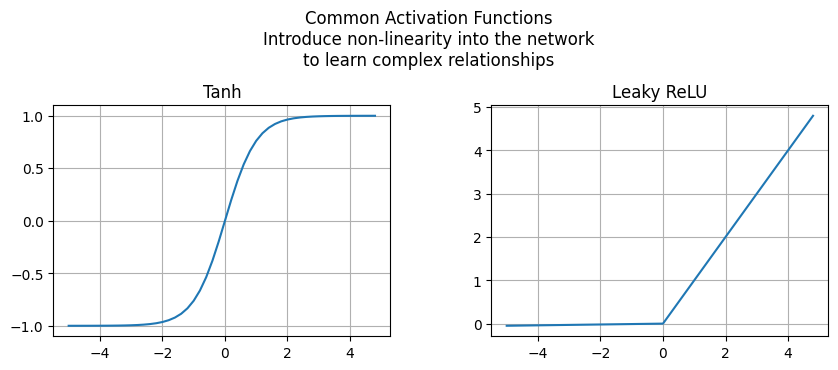

In [82]:
# Common Activation Functions
x = np.arange(-5, 5, 0.2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(x, np.tanh(x))
ax1.set_title("Tanh")
ax1.grid()

a = x[x < 0]*0.01
b = x[x >= 0]
y = np.concatenate((a, b))
ax2.grid()
ax2.plot(x, y)
ax2.set_title("Leaky ReLU")

plt_title = "Common Activation Functions\nIntroduce non-linearity into the network\nto learn complex relationships"
plt.suptitle(plt_title , fontsize=12, y=1.2)
plt.subplots_adjust(wspace=0.3)
plt.show()

##### Calculate Outputs and Loss Using Tanh Activation

In [83]:
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[-0.89043052 -0.21260965]
 [-0.19971903 -0.82070971]
 [-0.63691437 -0.88419629]]

input (2, 2):
[[ 2.e+00  3.e+03]
 [ 1.e+00 -2.e+00]]

weights_x_inputs (3, 2):
[[-1.99347069e+00 -2.67086633e+03]
 [-1.22014777e+00 -5.97515681e+02]
 [-2.15802503e+00 -1.90897471e+03]]

bias (3, 1):
[[ 0.53347948]
 [ 0.4381672 ]
 [-0.07204243]]

weights_x_inputs_+_bias (3, 2):
[[-1.45999121e+00 -2.67033286e+03]
 [-7.81980575e-01 -5.97077514e+02]
 [-2.23006746e+00 -1.90904676e+03]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[-0.89765089 -1.        ]
 [-0.65384204 -1.        ]
 [-0.97714264 -1.        ]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[-0.84451143 -0.51070881 -0.96158593]
 [ 0.79763906  0.81752411  0.11783603]
 [ 0.92455562 -0.93555016  0.96203182]]

input (3, 2):
[[-0.89765089 -1.        ]
 [-0.65384204 -1.        ]
 [-0.97714264 -

In [84]:
print(f'-- Neural network outputs and Loss --')
print(f'yout:           {yout} <-- neural network output')   
print(f'desired output: {ys} <-- target')   
print(f'err:            {err} <-- prediction_error')
print(f'err_sq:         {err_sq} <-- prediction_error^2')
print(f'loss_sum:       {loss_sum} <-- sum(prediction_error)^2')
print(f'loss_mean:      {loss_mean} <-- mean(prediction_error)^2')


-- Neural network outputs and Loss --
yout:           [0.52455843 0.64771646] <-- neural network output
desired output: [1.0, -1.0] <-- target
err:            [-0.47544157  1.64771646] <-- prediction_error
err_sq:         [0.22604469 2.71496955] <-- prediction_error^2
loss_sum:       2.9410142322694575 <-- sum(prediction_error)^2
loss_mean:      1.4705071161347287 <-- mean(prediction_error)^2


##### Save original parameters

In [85]:
# save original parameters
param_org = [p.data for p in n.parameters()]

#   &nbsp;
# - How Artificial Neural Network Learns -

##### * calculate gradients (i.e. changes in Loss w.r.t. changes in each parameter)<br>* use gradients to adjust parameters in direction of less Loss<br>* repeat the steps

##### Manual gradient calculation for parameter W0<br>* calculate outputs and Loss<br>* increase W0 by small amount, e.g. 0.00001<br>* recalculate outputs and Loss<br>* calculate gradient (W0_grad = changes_in_Loss / changes_in_W0)
##### Increase W0 by small amount

In [86]:
# Increase W0 by h
h = .000001
loss_mean_before = loss_mean
print(f'loss_mean before increase Wo:  {loss_mean_before:10.7f}')
W0_before = n.parameters()[0].data  # W1
print(f'W0_before:                     {W0_before:10.7f}')
n.parameters()[0].data += h
W0_after = n.parameters()[0].data
print(f'W0_after:                      {W0_after:10.7f}') 
W0_dif = W0_after - W0_before
print(f'W0_dif:                        {W0_dif:10.7f} <-- increased W0 by a small amount') 

loss_mean before increase Wo:   1.4705071
W0_before:                     -0.8904305
W0_after:                      -0.8904295
W0_dif:                         0.0000010 <-- increased W0 by a small amount


##### Recalculate output and Loss with small changes in W0

In [87]:
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[-0.89042952 -0.21260965]
 [-0.19971903 -0.82070971]
 [-0.63691437 -0.88419629]]

input (2, 2):
[[ 2.e+00  3.e+03]
 [ 1.e+00 -2.e+00]]

weights_x_inputs (3, 2):
[[-1.99346869e+00 -2.67086333e+03]
 [-1.22014777e+00 -5.97515681e+02]
 [-2.15802503e+00 -1.90897471e+03]]

bias (3, 1):
[[ 0.53347948]
 [ 0.4381672 ]
 [-0.07204243]]

weights_x_inputs_+_bias (3, 2):
[[-1.45998921e+00 -2.67032986e+03]
 [-7.81980575e-01 -5.97077514e+02]
 [-2.23006746e+00 -1.90904676e+03]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[-0.8976505  -1.        ]
 [-0.65384204 -1.        ]
 [-0.97714264 -1.        ]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[-0.84451143 -0.51070881 -0.96158593]
 [ 0.79763906  0.81752411  0.11783603]
 [ 0.92455562 -0.93555016  0.96203182]]

input (3, 2):
[[-0.8976505  -1.        ]
 [-0.65384204 -1.        ]
 [-0.97714264 -

##### Calculate gradient

In [88]:
loss_mean_after = loss_mean
loss_mean_dif = loss_mean_after - loss_mean_before
W0_grad = loss_mean_dif / W0_dif

print(f'-- Calculate outputs and changes in Loss --')

print(f'yout:              {yout}')   
print(f'desired output:    {ys}')   
print(f'err:               {err}')
print(f'err_sq:            {err_sq}')
print(f'loss_mean_before:  {loss_mean_before}')
print(f'loss_mean_after:   {loss_mean_after}\n')
print(f'-- Calcuclate gradient --')
print(f'loss_mean_dif:     {loss_mean_dif} <-- change in loss_mean')
print(f'W0_dif:            {W0_dif} <-- change in W0')
print(f'W0_grad:           {W0_grad} <-- (changes in loss_mean) / (changes in W0), manual calculation')

-- Calculate outputs and changes in Loss --
yout:              [0.52455847 0.64771646]
desired output:    [1.0, -1.0]
err:               [-0.47544153  1.64771646]
err_sq:            [0.22604464 2.71496955]
loss_mean_before:  1.4705071161347287
loss_mean_after:   1.4705070952726207

-- Calcuclate gradient --
loss_mean_dif:     -2.0862108041086458e-08 <-- change in loss_mean
W0_dif:            1.0000000000287557e-06 <-- change in W0
W0_grad:           -0.020862108040486556 <-- (changes in loss_mean) / (changes in W0), manual calculation


##### Calculate output and Loss with Micrograd<br>* change W0 back to initial value<br>* compare manual calculation vs Micrograd 

In [89]:
# change W0 back before Micrograd calculation
n.parameters()[0].data = W0_before

ypred = [n(x) for x in xs]
ypred_data = [v.data for v in ypred]  # extract data 
loss_mean = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) / len(ys) # low loss is better, perfect is loss = 0

print(f'-- Calculate neural network Loss and gradient using Micrograd --')
print(f'W0:          {n.parameters()[0].data}')
print(f'ypred_data:  {ypred_data}')
print(f'ys:          {ys}')
print(f'err_sq:      {err_sq}')
print(f'loss_mean:   {loss_mean.data} <-- loss_mean, Micrograd calculation same as manual calc. {loss_mean_before}')

-- Calculate neural network Loss and gradient using Micrograd --
W0:          -0.8904305180144918
ypred_data:  [0.5245584306425038, 0.6477164642001789]
ys:          [1.0, -1.0]
err_sq:      [0.22604464 2.71496955]
loss_mean:   1.4705071161347292 <-- loss_mean, Micrograd calculation same as manual calc. 1.4705071161347287


##### Calculate gradients and adjust parameters using Micrograd

In [90]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero gradients before calculating gradient wth backward pass 
loss_mean.backward()

# update weights and bias
print('-- adjust parameters,  parameter_after = parameter_before - gradient * learning_rate --')
print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad

  if i == 0:  
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f} <-- gradient same as manual calc. W0_grad {W0_grad:13.10f}')
  else:
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')    

-- adjust parameters,  parameter_after = parameter_before - gradient * learning_rate --
  i  parameter before         gradient     learning rate      parameter after
  0     -0.8904305180    -0.0208620675           0.02500        -0.8899089663 <-- gradient same as manual calc. W0_grad -0.0208621080
  1     -0.2126096493    -0.0104310337           0.02500        -0.2123488734
  2      0.5334794803    -0.0104310337           0.02500         0.5337402561
  3     -0.1997190335     0.2438769020           0.02500        -0.2058159561
  4     -0.8207097062     0.1219384510           0.02500        -0.8237581674
  5      0.4381671980     0.1219384510           0.02500         0.4351187367
  6     -0.6369143690    -0.0049794176           0.02500        -0.6367898836
  7     -0.8841962900    -0.0024897088           0.02500        -0.8841340472
  8     -0.0720424332    -0.0024897088           0.02500        -0.0719801904
  9     -0.8445114275    -0.0862938535           0.02500        -0.842354081

In [91]:
# graph the data and gradients, a bit confusing to visualized 
# draw_dot(loss_mean)

##### Repeat the steps using Micrograd:<br>* calculate Loss<br>* calculate gradient<br>* adjust parameters in direction of less Loss

In [92]:
# Create a list of losses
losses_mean = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  # loss is mean-square-errors
  loss_mean = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) / len(ys) # low loss is better, perfect is loss = 0  
  losses_mean.append(loss_mean.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss_mean.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss_mean: {loss_mean.data}')   
  # print('-------')

ypred: [Value(data = 0.4838298350934461), Value(data = 0.6045780879082783)]
step: 0, loss_mean: 1.4205512396675226
ypred: [Value(data = 0.4403740456975817), Value(data = 0.5575375293995289)]
step: 1, loss_mean: 1.3695521821084404
ypred: [Value(data = 0.39503631696243396), Value(data = 0.5074594387694555)]
step: 2, loss_mean: 1.3192075086647492
ypred: [Value(data = 0.3489565570938235), Value(data = 0.45561054137508894)]
step: 3, loss_mean: 1.2713298063567036
ypred: [Value(data = 0.30344970103235563), Value(data = 0.4035316598032638)]
step: 4, loss_mean: 1.2275417195310094
ypred: [Value(data = 0.2598245231431254), Value(data = 0.35282127607535674)]
step: 5, loss_mean: 1.1889925707712294
ypred: [Value(data = 0.21919621321766392), Value(data = 0.304896986416154)]
step: 6, loss_mean: 1.156205349305798
ypred: [Value(data = 0.18235424484820612), Value(data = 0.26081516336033966)]
step: 7, loss_mean: 1.1290997285385538
ypred: [Value(data = 0.1497185627046196), Value(data = 0.2211970257342078)]

##### Plot Loss

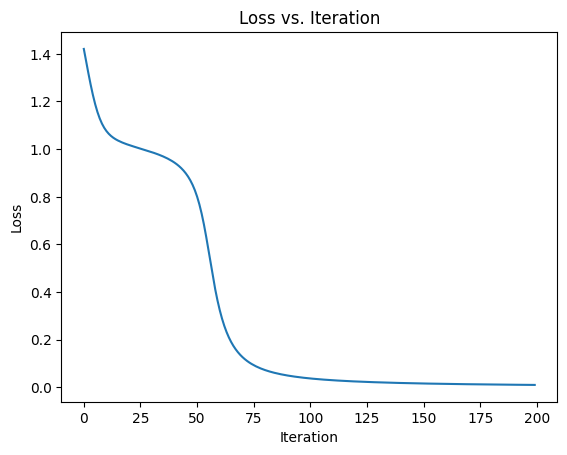

In [93]:
plot_losses(losses_mean)

##### Calculate outputs and Loss after last parameter adjustment

In [94]:
# calculate outputs and Loss after last parameter adjustment
ypred = [n(x) for x in xs]
loss_mean = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) / len(ys) # low loss is better, perfect is loss = 0
ypred_data = [value.data for value in ypred]

print(f'\n-- Calculate outputs and Loss at end of iteration --')
print(f'ypred_data: {ypred_data}')
print(f'loss_mean: {loss_mean.data}\n\n')

# check calculation using forward pass function
print(f'Calculate outputs and Loss using optimized parameters')
yout, err, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)


-- Calculate outputs and Loss at end of iteration --
ypred_data: [0.908608735864421, -0.8878531830199923]
loss_mean: 0.010464635859523255


Calculate outputs and Loss using optimized parameters
--------------------------------------------------
Calculate Output of Layer: 0
weights (3, 2):
[[-0.11313095  0.17604013]
 [-0.52916541 -0.98543289]
 [-0.58355606 -0.85751714]]

input (2, 2):
[[ 2.e+00  3.e+03]
 [ 1.e+00 -2.e+00]]

weights_x_inputs (3, 2):
[[-5.02217722e-02 -3.39744939e+02]
 [-2.04376370e+00 -1.58552535e+03]
 [-2.02462926e+00 -1.74895316e+03]]

bias (3, 1):
[[ 0.92212926]
 [ 0.27344401]
 [-0.04536328]]

weights_x_inputs_+_bias (3, 2):
[[ 8.71907491e-01 -3.38822809e+02]
 [-1.77031969e+00 -1.58525191e+03]
 [-2.06999254e+00 -1.74899852e+03]]

Layer 0 Output = tanh(weights_x_inputs_+_bias) (3, 2):
[[ 0.70234198 -1.        ]
 [-0.94364445 -1.        ]
 [-0.96865296 -1.        ]]

--------------------------------------------------
Calculate Output of Layer: 1
weights (3, 3):
[[-0.81

##### Compare changes in parameters after optimization

In [95]:
# save parameters
param_optmz = [p.data for p in n.parameters()]
param_comp = zip(param_org, param_optmz)

# print(f'i        param_new      param_org      param_dif')
print(f'i  param. optimized  param. orginal     param. dif')
for i, param_org_new in enumerate(param_comp):
  p_org = param_org_new[0]
  p_new = param_org_new[1]  
  p_dif = p_new - p_org
  print(f'{i:<4} {p_new:>14.10f}  {p_org:>14.10f} {p_dif:>14.10f}')  


i  param. optimized  param. orginal     param. dif
0     -0.1131309528   -0.8904305180   0.7772995653
1      0.1760401333   -0.2126096493   0.3886497826
2      0.9221292629    0.5334794803   0.3886497826
3     -0.5291654057   -0.1997190335  -0.3294463722
4     -0.9854328923   -0.8207097062  -0.1647231861
5      0.2734440119    0.4381671980  -0.1647231861
6     -0.5835560631   -0.6369143690   0.0533583059
7     -0.8575171370   -0.8841962900   0.0266791529
8     -0.0453632802   -0.0720424332   0.0266791529
9     -0.8118290173   -0.8445114275   0.0326824102
10    -0.5597225605   -0.5107088067  -0.0490137539
11    -1.0478732292   -0.9615859326  -0.0862872966
12    -0.9014151234   -0.9961242330   0.0947091095
13     0.8760295520    0.7976390583   0.0783904937
14     0.7807722496    0.8175241102  -0.0367518606
15     0.0716310892    0.1178360261  -0.0462049370
16     0.5696991998    0.5190997400   0.0505994598
17     1.3254728600    0.9245556247   0.4009172353
18    -0.8149965115   -0.935550

#   &nbsp;
# - Build the Same Model Using PyTorch -

In [96]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(2, 3)
        self.fc2 = nn.Linear(3, 3)
        self.fc3 = nn.Linear(3, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)  
        return x

model = MLP_torch()

# # inputs
# xs = [
#   [2.0, 3.0, -1.0],
#   [3.0, -1.0, 0.5]
# ]

# # desired targets
# ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# # learning rate (i.e. step size)
# learning_rate = 0.05

losses = []
for epoch in range(200):
    # forward pass
    predictions = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(predictions, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Predictions:\n{predictions.detach()}")
        print(f"Epoch {epoch} loss: {loss}")

predictions = model(t_xs)
print('')
print(f"Predictions:\n{predictions.detach()}")
print(f"Loss: {loss}")

Predictions:
tensor([[0.4685],
        [0.5667]])
Epoch 0 loss: 1.3685442209243774
Predictions:
tensor([[0.1022],
        [0.1783]])
Epoch 10 loss: 1.0971802473068237
Predictions:
tensor([[0.0276],
        [0.0751]])
Epoch 20 loss: 1.0507335662841797
Predictions:
tensor([[0.0026],
        [0.0355]])
Epoch 30 loss: 1.0335309505462646
Predictions:
tensor([[-0.0050],
        [ 0.0193]])
Epoch 40 loss: 1.0244625806808472
Predictions:
tensor([[-0.0065],
        [ 0.0121]])
Epoch 50 loss: 1.018742322921753
Predictions:
tensor([[-0.0061],
        [ 0.0086]])
Epoch 60 loss: 1.0147830247879028
Predictions:
tensor([[-0.0051],
        [ 0.0067]])
Epoch 70 loss: 1.011878490447998
Predictions:
tensor([[-0.0041],
        [ 0.0056]])
Epoch 80 loss: 1.009655237197876
Predictions:
tensor([[-0.0031],
        [ 0.0047]])
Epoch 90 loss: 1.0078942775726318
Predictions:
tensor([[-0.0023],
        [ 0.0041]])
Epoch 100 loss: 1.0064585208892822
Predictions:
tensor([[-0.0017],
        [ 0.0036]])
Epoch 110 los

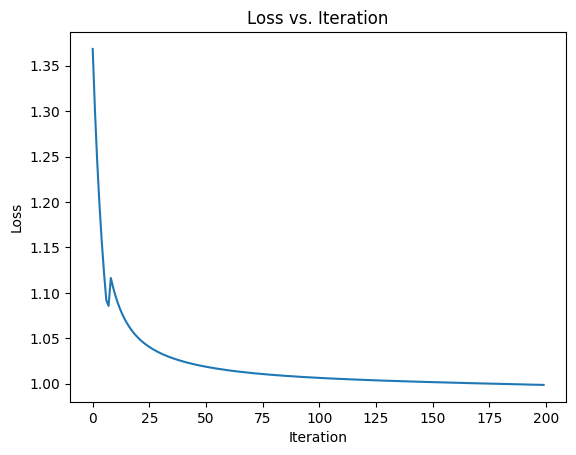

In [97]:
plot_losses(losses)

In [98]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')


print(f'-- manual calculation of output for each layer from the optimized pytorch model --')
# l_items is a list of [weight matrix, bias matrix, ..., weight matrix, bias matrix] 
l_items = list(model.parameters())
if len(l_items) % 2 == 0:  # True divisible by 2
  for i in range(0, len(l_items), 2):  # i: 0, 2, ..., len(l_items)-2
    if i == 0:  # use transposed t_xs as input only at the first time
      x0 = torch.clone(t_xs).detach()  # clone t_xs without autograd history
      input = torch.transpose(x0, 0, 1)  # columns of x0 becomes rows of input
    else:  # use previous output as input 
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 1.0], [3000.0, -2.0]]

target ys:
[1.0, -1.0]
---------

-- manual calculation of output for each layer from the optimized pytorch model --
layer: 0.0,  i: 0

w,  torch.Size([3, 2]):
tensor([[-2.8012,  0.1473],
        [-0.5432, -0.0977],
        [-0.4844, -0.5572]])

input,  torch.Size([2, 2]):
tensor([[ 2.0000e+00,  3.0000e+03],
        [ 1.0000e+00, -2.0000e+00]])

w * input,  torch.Size([3, 2]):
tensor([[-5.4552e+00, -8.4040e+03],
        [-1.1841e+00, -1.6294e+03],
        [-1.5260e+00, -1.4521e+03]])

bT,  torch.Size([3, 1]):
tensor([[-0.5130],
        [-0.6173],
        [ 0.0765]])

w * input + bT,  torch.Size([3, 2]):
tensor([[-5.9682e+00, -8.4045e+03],
        [-1.8014e+00, -1.6300e+03],
        [-1.4495e+00, -1.4520e+03]])

output,  torch.Size([3, 2]):
tensor([[-1.0000, -1.0000],
        [-0.9470, -1.0000],
        [-0.8956, -1.0000]])


layer: 1.0,  i: 2

w,  torch.Size([3, 3]):
tensor([[ 0.4601,  0.0977, -0.2045],
        [ 0.5125, -0.3685, -0.0489],
      

#   &nbsp;
# - Additional Information from PyTorch Model -

In [99]:
for module in model.modules():
  classname = module.__class__.__name__
  print(classname)
  # if 'Linear' in classname:
  #   # module = nn.Sequential(...)
  #   print(classname)


MLP_torch
Linear
Linear
Linear


In [100]:
t_xs.shape

torch.Size([2, 2])

In [101]:
from torchsummary import summary
summary(model, t_xs.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2, 3]               9
            Linear-2                 [-1, 2, 3]              12
            Linear-3                 [-1, 2, 1]               4
Total params: 25
Trainable params: 25
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [102]:
for name, param in model.named_parameters():
  param = param.detach()  # remove grad
  print(f'name: {name}')
  print(f'param: {param}')

  if name.find('weight') !=-1: # found
    print(f'weight matrix')
  elif name.find('bias') !=-1: # found
    print(f'bias matrix')
  else:
    raise ValueError(f"parameter name does not have 'weight' or 'bias' in the name")
 
  print('\n')  

name: fc1.weight
param: tensor([[-2.8012,  0.1473],
        [-0.5432, -0.0977],
        [-0.4844, -0.5572]])
weight matrix


name: fc1.bias
param: tensor([-0.5130, -0.6173,  0.0765])
bias matrix


name: fc2.weight
param: tensor([[ 0.4601,  0.0977, -0.2045],
        [ 0.5125, -0.3685, -0.0489],
        [-0.3030, -0.3744,  0.1095]])
weight matrix


name: fc2.bias
param: tensor([-0.0217, -0.2748, -0.0614])
bias matrix


name: fc3.weight
param: tensor([[ 0.1765, -0.1402, -0.1205]])
weight matrix


name: fc3.bias
param: tensor([0.0698])
bias matrix


